In [316]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import requests
import os
import datetime as dt
from datetime import timedelta, date

# EDA

First we need to import the incident list dataframe

In [317]:
df = pd.read_csv('df.csv')

The longitude and latitude of each address was found in the 'Google Geocoding API' notebook. We'll import a dataframe of all unique addresses with their coordinates and indicent count here.

In [318]:
df_address_geo = pd.read_csv('df_address_geo.csv')

Now we add the coordinates to the incidents dataframe

In [319]:
df = df.merge(df_address_geo.drop('incidentCount', axis=1), on='address', how='left')
df.head()

,ccn,date,city,state,blocksizedAddress,parentIncidentType,narrative,address,lat,lng
0,CA23018227,"12/25/2022, 12:00:00 AM",LETHBRIDGE,AB,1600 Block ST GEORGE RD,Assault,Assault,"1600 ST GEORGE RD, LETHBRIDGE, AB, Canada",49.719971,-112.832000
1,CA23016523,"12/01/2022, 9:04:00 AM",LETHBRIDGE,AB,100 Block GOLDENROD RD,Other,Fraud - Identity Fraud,"100 GOLDENROD RD, LETHBRIDGE, AB, Canada",49.693938,-112.910940
2,RM23054146,"10/21/2022, 4:00:00 PM",LETHBRIDGE,AB,100 Block FAIRMONT BD,Other,Proceeds Of Crime Criminal Cod,"100 FAIRMONT BD, LETHBRIDGE, AB, Canada",49.666273,-112.789834
3,CA23008687,"11/01/2022, 7:00:00 AM",LETHBRIDGE,AB,1 Block BLACKFOOT CI,Sexual Offense,Sexual Assault,"1 BLACKFOOT CI, LETHBRIDGE, AB, Canada",49.679674,-112.896003
4,RM22058254,"12/16/2022, 1:00:00 PM",LETHBRIDGE,AB,100 Block 1 AV,Other,Assist Others,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058


Let's visualize the number of incidents for each block on a scatter plot

In [320]:
df.to_csv('df2.csv',index=False)

In [321]:
df_address_geo['incidentCount'].max()

2193

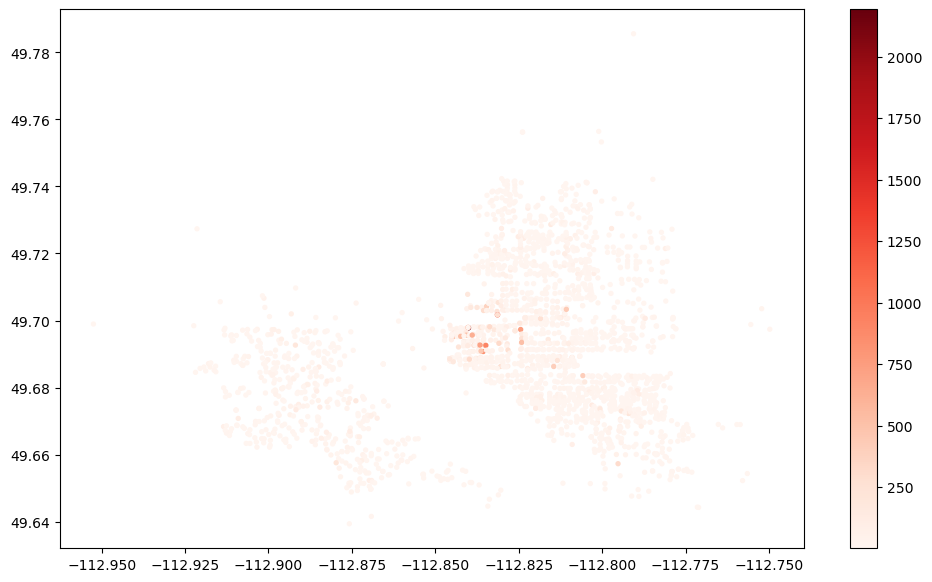

In [322]:
plt.figure(figsize=(12,7))
plt.scatter(df_address_geo['lng'], df_address_geo['lat'], c=df_address_geo['incidentCount'], cmap='Reds', s=8)
plt.colorbar()

## Creating Block-Date DataFrame

Now we need to make a dataframe where each row is a unique 'block-hour'.  Let's start by converting date strings to datetimes.

In [323]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

/var/folders/t5/t3vd2l292dz2vlb6dq_km0fh0000gn/T/ipykernel_49498/63736465.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
/var/folders/t5/t3vd2l292dz2vlb6dq_km0fh0000gn/T/ipykernel_49498/63736465.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)


In [324]:
df_incidentBlockDate = df.pivot_table(index=['address', df['date'].dt.date], values='lat', aggfunc='count').reset_index()
df_incidentBlockDate.columns = ['address','date','incidentCount']
df_incidentBlockDate['date'] = pd.to_datetime(df_incidentBlockDate['date'])

In [325]:
# Creating a dataframe that has a row for every combination of address (block) and date

date_min = df['date'].min().date()
date_max = df['date'].max().date() + timedelta(days=1)

addresses = df_address_geo['address']
dates = pd.date_range(start=date_min, end=date_max)
time_interval = ['00:00-06:00', '06:00-12:00', '12:00-18:00', '18:00-24:00']

df_blockDate = pd.DataFrame([(a,d) for a in addresses for d in dates])
df_blockDate.columns = ['address', 'date']
df_blockDate = df_blockDate.merge(df_incidentBlockDate, on=['address','date'], how='left').fillna(0)

df_blockDate = df_blockDate.merge(df_address_geo.drop('incidentCount', axis=1), on='address', how='left')
df_blockDate.columns = ['address', 'date', 'incidentCount', 'lat', 'lng']

df_blockDate.insert(5, 'incidentOccurred?', (df_blockDate['incidentCount'] > 0)*1)
df_blockDate.insert(2, 'dayOfWeek', df_blockDate['date'].dt.strftime('%A'))

df_blockDate

,address,date,dayOfWeek,incidentCount,lat,lng,incidentOccurred?
0,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-01,Saturday,0.0,49.697474,-112.850887,0
1,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-02,Sunday,0.0,49.697474,-112.850887,0
2,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-03,Monday,0.0,49.697474,-112.850887,0
3,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-04,Tuesday,0.0,49.697474,-112.850887,0
4,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-05,Wednesday,0.0,49.697474,-112.850887,0
...,...,...,...,...,...,...,...
611870,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-28,Wednesday,0.0,49.714012,-112.838589,0
611871,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-29,Thursday,0.0,49.714012,-112.838589,0
611872,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-30,Friday,0.0,49.714012,-112.838589,0
611873,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-07-01,Saturday,0.0,49.714012,-112.838589,0


In [326]:
df_incidentChance = df_blockDate.pivot_table(index='address', values='incidentOccurred?', aggfunc='mean').reset_index()
df_incidentChance.columns = ['address', 'incidentChance']

df_timeseries = df_blockDate.pivot_table(index='date', values='incidentCount', aggfunc='sum').reset_index()

In [327]:
df_timeseries['date'][:-2]

0     2022-10-01
1     2022-10-02
2     2022-10-03
3     2022-10-04
4     2022-10-05
         ...    
268   2023-06-26
269   2023-06-27
270   2023-06-28
271   2023-06-29
272   2023-06-30
Name: date, Length: 273, dtype: datetime64[ns]

(0.0, 300.0)

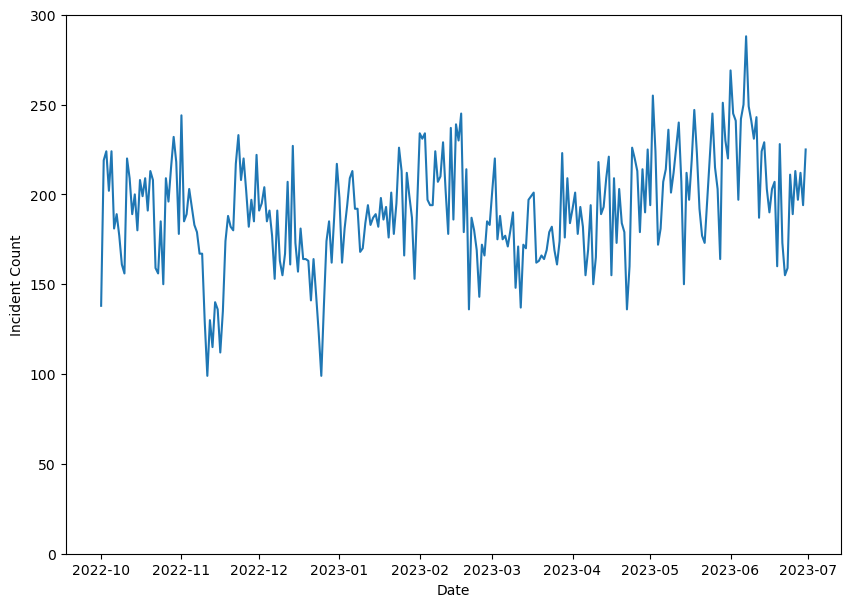

In [328]:
plt.figure(figsize=(10,7))
plt.plot(df_timeseries['date'][:-2],df_timeseries['incidentCount'][:-2])
plt.ylabel('Incident Count')
plt.xlabel('Date')
plt.ylim(0, 300)

In [329]:
df_blockDate['incidentOccurred?'].value_counts()

incidentOccurred?
0    584249
1     27626
Name: count, dtype: int64

In [330]:
df_blockDate

,address,date,dayOfWeek,incidentCount,lat,lng,incidentOccurred?
0,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-01,Saturday,0.0,49.697474,-112.850887,0
1,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-02,Sunday,0.0,49.697474,-112.850887,0
2,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-03,Monday,0.0,49.697474,-112.850887,0
3,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-04,Tuesday,0.0,49.697474,-112.850887,0
4,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-05,Wednesday,0.0,49.697474,-112.850887,0
...,...,...,...,...,...,...,...
611870,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-28,Wednesday,0.0,49.714012,-112.838589,0
611871,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-29,Thursday,0.0,49.714012,-112.838589,0
611872,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-30,Friday,0.0,49.714012,-112.838589,0
611873,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-07-01,Saturday,0.0,49.714012,-112.838589,0


In [331]:
df[df['date'].dt.date==date(2022,10,5)]

,ccn,date,city,state,blocksizedAddress,parentIncidentType,narrative,address,lat,lng
68,CA22022522,2022-10-05 15:00:00,LETHBRIDGE,AB,1800 Block 23 ST,Other,Check On Welfare,"1800 23 ST, LETHBRIDGE, AB, Canada",49.720937,-112.810393
410,CA22022053,2022-10-05 06:16:00,LETHBRIDGE,AB,2300 Block 13 ST,Theft from Vehicle,Theft From Auto Under,"2300 13 ST, LETHBRIDGE, AB, Canada",49.725008,-112.825161
4663,AR22100771,2022-10-05 23:04:00,LETHBRIDGE,AB,1 Block HERITAGE BD,Theft from Vehicle,Mischief to MV,"1 HERITAGE BD, LETHBRIDGE, AB, Canada",49.693513,-112.888448
11149,CA22022099,2022-10-05 17:12:00,LETHBRIDGE,AB,1 Block PARK MEADOWS BD,Other,Check On Welfare,"1 PARK MEADOWS BD, LETHBRIDGE, AB, Canada",49.721026,-112.810262
12517,CA22022040,2022-10-05 03:51:00,LETHBRIDGE,AB,1100 Block 27 ST,Other,Landlord & Tenant,"1100 27 ST, LETHBRIDGE, AB, Canada",49.681706,-112.802900
...,...,...,...,...,...,...,...,...,...,...
15942,P22047143,2022-10-05 01:53:25,LETHBRIDGE,AB,500 Block STAFFORD DR,Quality of Life,DISTURBANCE/NUISANCE,"500 STAFFORD DR, LETHBRIDGE, AB, Canada",49.705223,-112.833880
15943,P22047144,2022-10-05 01:54:15,LETHBRIDGE,AB,500 Block 21 ST,Other,"PUBLIC SERVICE (LOCK-OUT/LOCK-IN, PEACE, WELFA...","500 21 ST, LETHBRIDGE, AB, Canada",49.693111,-112.811428
15947,P22047130,2022-10-05 00:03:29,LETHBRIDGE,AB,200 Block 4 AV,Other,SUPPLEMENTAL,"200 4 AV, LETHBRIDGE, AB, Canada",49.693695,-112.841379
15948,P22047132,2022-10-05 00:17:26,LETHBRIDGE,AB,600 Block 8 ST,Sexual Offense,SEXUAL ASSAULT,"600 8 ST, LETHBRIDGE, AB, Canada",49.690751,-112.835657


In [332]:
df_blockDate_training

,address,date,dayOfWeek,incidentCount,lat,lng,incidentOccurred?
0,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-01,Saturday,0.0,49.697474,-112.850887,0
1,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-02,Sunday,0.0,49.697474,-112.850887,0
2,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-03,Monday,0.0,49.697474,-112.850887,0
3,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-04,Tuesday,0.0,49.697474,-112.850887,0
4,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-05,Wednesday,0.0,49.697474,-112.850887,0
...,...,...,...,...,...,...,...
611838,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-05-27,Saturday,0.0,49.714012,-112.838589,0
611839,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-05-28,Sunday,0.0,49.714012,-112.838589,0
611840,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-05-29,Monday,0.0,49.714012,-112.838589,0
611841,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-05-30,Tuesday,0.0,49.714012,-112.838589,0


In [333]:
df_address_geo = df_address_geo.sort_values('incidentCount',ascending = False).reset_index(drop=True)
df_address_geo['incidentCummSum'] = np.cumsum(df_address_geo['incidentCount'])/df_address_geo['incidentCount'].sum()

In [334]:
df_address_geo

,address,incidentCount,lat,lng,incidentCummSum
0,"100 1 AV, LETHBRIDGE, AB, Canada",2193,49.697816,-112.840058,0.041909
1,"800 2A AV, LETHBRIDGE, AB, Canada",1361,49.701727,-112.831368,0.067918
2,"800 5 AV, LETHBRIDGE, AB, Canada",925,49.692594,-112.834855,0.085595
3,"500 1 AV, LETHBRIDGE, AB, Canada",864,49.697940,-112.840158,0.102106
4,"600 8 ST, LETHBRIDGE, AB, Canada",832,49.690751,-112.835657,0.118006
...,...,...,...,...,...
2220,"1000 2A, LETHBRIDGE, AB, Canada",1,49.695618,-112.845107,0.999924
2221,"1 ST & ST EDWARD BD, LETHBRIDGE, AB, Canada",1,49.720126,-112.829140,0.999943
2222,"1600 26 ST, LETHBRIDGE, AB, Canada",1,49.675920,-112.804433,0.999962
2223,"1 ST & 41 AV, LETHBRIDGE, AB, Canada",1,49.695618,-112.845107,0.999981


Text(0, 0.5, 'Cummulative % of Incidents')

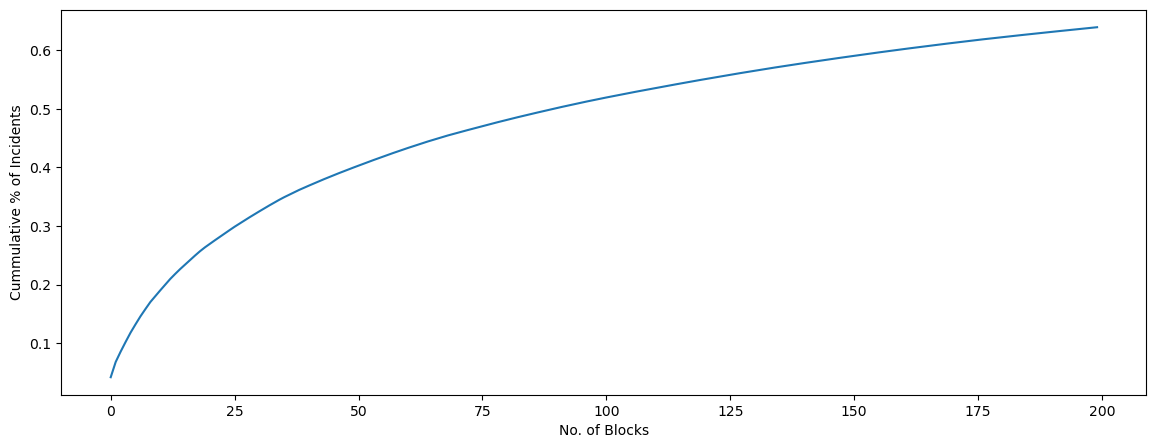

In [335]:
plt.figure(figsize=(14,5))
plt.plot(df_address_geo.head(200).index,df_address_geo.head(200)['incidentCummSum'])
plt.xlabel('No. of Blocks')
plt.ylabel('Cummulative % of Incidents')


Text(0, 0.5, 'Incident Count')

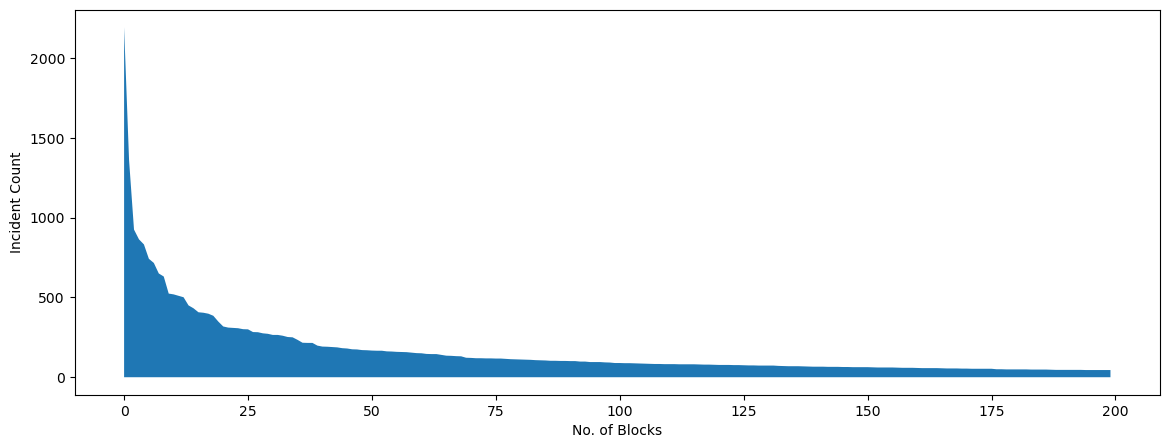

In [336]:
plt.figure(figsize=(14,5))
plt.fill_between(df_address_geo.head(200).index,df_address_geo.head(200)['incidentCount'])
plt.xlabel('No. of Blocks')
plt.ylabel('Incident Count')

# Machine Learning Models

## Splitting Training and Testing Data

In [337]:
df_blockDate_training = df_blockDate[df_blockDate['date'].dt.date < date(2023,6,1)]
df_blockDate_test = df_blockDate[
    (df_blockDate['date'].dt.date >= date(2023,6,1)) &
    (df_blockDate['date'].dt.date < date(2023,7,1))
]

## All-Time Hotspots

In [338]:
# Assuming Lethbridge can have 30 patrol cars one the roads at one time
policeCarsCount = 30

df_hotspot = df_blockDate_training.pivot_table(index='address', values='incidentOccurred?', aggfunc='mean').reset_index()
df_hotspot = df_hotspot.sort_values('incidentOccurred?',ascending=False)
df_hotspot.columns = ['address','incidentChance']
df_hotspot = df_hotspot.head(policeCarsCount)

In [339]:
df_blockDate_test['Hotspot Prediction'] = df_blockDate_test['address'].isin(df_hotspot['address'])*1

/var/folders/t5/t3vd2l292dz2vlb6dq_km0fh0000gn/T/ipykernel_49498/359809479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blockDate_test['Hotspot Prediction'] = df_blockDate_test['address'].isin(df_hotspot['address'])*1


In [340]:
def print_confusion_matrix(y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    cf = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cf, annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Confusion Matrix')

In [341]:
df_test = df_blockDate[['address', 'incidentOccurred?']].pivot_table(index='address', values='incidentOccurred?', aggfunc='mean').reset_index()
df_test.columns = ['address', 'daysWithIncidentPercent']

df_address_geo2 = df_address_geo.merge(df_test, on='address', how='left').sort_values('incidentCount', ascending=False)
df_address_geo2.to_csv('df_address_geo2.csv')

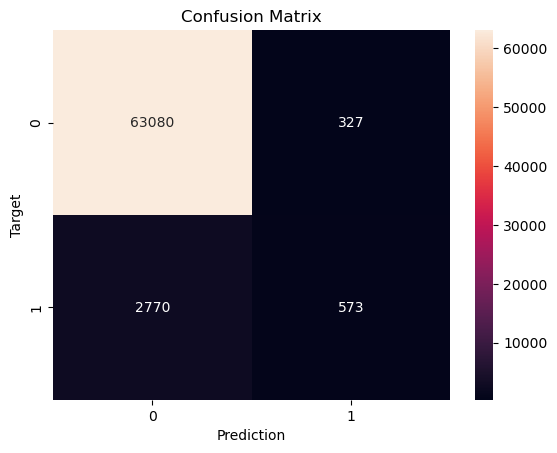

In [342]:
print_confusion_matrix(df_blockDate_test['incidentOccurred?'], df_blockDate_test['Hotspot Prediction'])

In [345]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
print(classification_report(df_blockDate_test['incidentOccurred?'], df_blockDate_test['Hotspot Prediction']))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     63407
           1       0.64      0.17      0.27      3343

    accuracy                           0.95     66750
   macro avg       0.80      0.58      0.62     66750
weighted avg       0.94      0.95      0.94     66750



## Logistic Regression

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Select features and target variable
X = data.drop(columns=['target'])
y = data['target']

# One-hot encode categorical variables
categorical_columns = ['color', 'country']
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = encoder.fit_transform(X[categorical_columns])

# Combine encoded features with non-categorical features
X_final = pd.concat([X.drop(columns=categorical_columns), pd.DataFrame(X_encoded, columns=encoder.get_feature_names(categorical_columns))], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

## Random Forest Classifier

In [ ]:
df_blockDate_training['lat_bucket'] = pd.qcut(df_blockDate_training['lat'], q=[0,0.2,0.4,0.6,0.8,1], labels=['A','B','C','D','E'])
df_blockDate_training['lng_bucket'] = pd.qcut(df_blockDate_training['lng'], q=[0,0.2,0.4,0.6,0.8,1], labels=['A','B','C','D','E'])

In [ ]:
df_randomForest = df_blockDate_training[['incidentOccurred?','dayOfWeek','lat_bucket','lng_bucket']]

In [ ]:
# Training the random forest classifier model

"""
X_train = df_randomForest.drop('incidentOccurred?',axis=1)
y_train = df_randomForest['incidentOccurred?']

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
"""